In [1]:
#%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import os
from astropy import constants as const
import h5py

#these modules shuould all be in your current directory, as well as the line_lists directory
from atmospheric_model import semianalytical, xs_DACE_multi
import preprocessing
from mini_inferno import apply_uniform_logPrior


## Overview

This tutorial is going to walk through a simple retrieval performed on a simulated dataset. The main emphasis of the tutorial is to get you thinking about the various steps required to match the model to the data, with a particular focus on accounting for PCA or SysRem preprocessing of the data. DISCLAIMER: There are several different ways to achieve this, and this is not intended to be a difinitive version of data preprocessing and model filtering (in fact, I threw this together quite quickly and wouldn't be surprised if there're biases in the methodology here!).

## The Dataset

The data are a simulated transit dataset based on real CRIRES+ spectra. The object is a hot Jupiter with H$_2$O and CO injected into the transmission signal. The specific planet parameters used for the injection are also included with the data. All wavelengths are in Angstrom.

First let's load in the data and check the format. You can either use the `.npz` or `.h5` format to load. The dataset contains the 3D datacubes of the spectra and noise (S and Se, respectively) ordered as [order $\times$ time $\times$ wl]. The wavelengths are stored in W [order $\times$ wl], and the time [BJD] is stored in time along with the period and central transit time.

Let's first load up the data and make some basic plots.

In [2]:
# load in .npz file as a dictionary
d = dict(np.load('simulated_data.npz'))
# or load in .h5 file as dictionary
#with h5py.File('simulated_data.h5','r') as F: d = {k:F[k][()] for k in F}

#check the contents of the data dictionary
print(d.keys())

# compute the phase
ph = (d['bjd'] - d['T0']) / d['period'] - 1131 # subtract epoch
W,S,Se = d['W'],d['S'],d['Se']

#compute transit weighting from the transit model
tmodel = d['transit']
tweight = (1. - tmodel) / np.ptp(tmodel)

#get the injected model parameters
p_inject = d['p_inject']
print(p_inject)
Temp,Pcloud,Xray,dv,Xh2o,Xco = p_inject # store the injected model parameters for later
Kp=200
v_sys=0

#print out some details of the datasets
print("S.shape =", S.shape)
print("Se.shape =", Se.shape)
print("W.shape =", W.shape)
print("ph.shape =", ph.shape)

dict_keys(['S', 'Se', 'W', 'bjd', 'ph', 'T0', 'period', 'wl_model', 'transit', 'p_inject'])
[2.20000000e+03 1.00000000e-02 1.00000000e+00 5.02164391e+00
 1.00000000e-05 1.00000000e-05]
S.shape = (18, 100, 2048)
Se.shape = (18, 100, 2048)
W.shape = (18, 2048)
ph.shape = (100,)


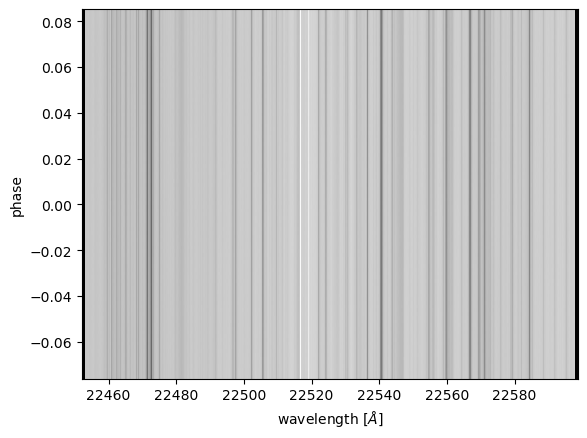

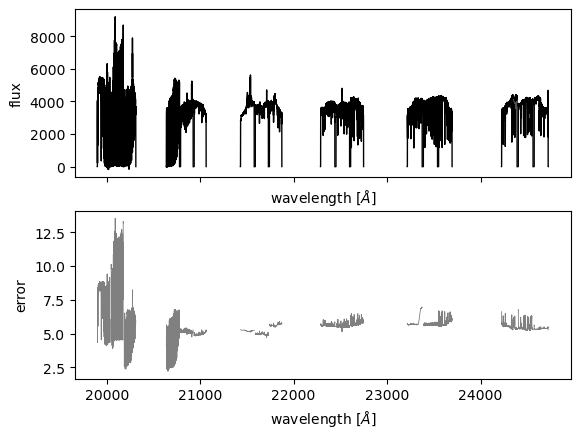

In [3]:
order = 10 # define test order

# plot one of the orders
ax = plt.subplot(xlabel=r'wavelength [$\AA$]',ylabel='phase')
ax.pcolormesh(W[order],ph,S[order])

#plot the spectra + uncertainties
fig, ax = plt.subplots(2,sharex=1)
ax[0].set(xlabel=r'wavelength [$\AA$]',ylabel='flux')
ax[1].set(xlabel=r'wavelength [$\AA$]',ylabel='error')
for w,spec in zip(W,S[:,10]): ax[0].plot(w,spec,lw=1,color='k')
for w,spec_err in zip(W,Se[:,10]): ax[1].plot(w,spec_err,lw=0.6,color='0.5')


### The Atmospheric Model

We're going to use a simple semi-analytic model of Heng & Kitzmann (2017) that I also used in Gibson et al. (2020) in a slightly modified form. This is:
$$
R(\lambda)=R_{0}+H\left[\gamma+\ln \left(\frac{P_{0}}{\bar mg} \sqrt{\frac{2 \pi R_{0}}{H}}\right)\right] + H \ln\sum_j \chi_j \sigma_j(\lambda),
$$
where $R_0$, $P_0$ are the reference radius and pressure, $H = \frac{kT}{\bar mg}$ is the atmopsheric scale height, $g$ is the surface gravity, $\chi_j$ is the abundance of species $j$, and $\sigma_j$ is the atmospheric cross-section for species $j$, which is interpolated to a temperature $T$.

I have also included a braodening parameter, $\Delta V$, which is the standard deviation of a Gaussian broadening kernel. Note that in order for this to make sense, the wavelength has to be sampled in a very specific way (i.e. logarithmically with $d\ln\lambda = {\rm const}$) in order to have a constant resolution (and therefore constant velocity spacing). It is useful to remember that the resolution of a spectrograph also changes with wavelength, and therefore it is extremely tricky to apply an instrumental profile to our model spectrum. (But that is not important here, as our simulated spectrum is only broadened using the Gaussian kernel.)

The full parameter vector for the 1D model is: [$T$,$P_{\rm cloud}$,$\chi_{\rm ray}$,$\Delta V$,$\chi_{\rm H_2O}$,$\chi_{\rm CO}$]

The model assumes an isothermal atmosphere and isobaric (at least for the cross-sections). This is a very fast and simple model that is very useful to play around with to test the retreival framework. However, there are some important limitations in addition to the isothermal assumption. For example, as the cross-sections have no pressure sensitivity, and the mean molecular weight is fixed and not linked to the abundance (this could be modified of course), the cloud deck pressure and abundances are completely degenerate. In other words you can increase both the abundance of water and CO by a factor of 10, and raise the cloud deck (or corresponding scattering parameter), and you will get an identical atmosphere (plus vertical offset). This leads to strong degeneracies in the abundances, and it is probably easier to just fix one of the abundances to begin with. The relative abundances on the other hand should be well constrained.

There are quite a few differnet modes for the model:
- tspec_r: (effective) planet radius
- tspec_rprs: planet-to-star radius ratio
- tspec_nf: negative flux, i.e. $1-(R_{\rm p}/R_\star)^2$
- tspec_ndf: negative 'differential' flux, this is after subtracting the continuum.

It is important to consider which one to use for differnet approaches.


getting H2O opacities from path: line_lists/1H2-16O_POKAZATEL
wl limits: [np.float64(19799.809773534947), np.float64(24823.46852671008)]
returning wl, pressure, temperature, xs with ranges:
 wl:     [19799.809773534947 -> 24823.46852671008]
 temp:     [1000 -> 2900] K (13 samples)
 pressure: [0.01 -> 0.01] bar (1 samples)
getting CO opacities from path: line_lists/12C-16O_HITEMP2019
wl limits: [np.float64(19799.809773534947), np.float64(24823.46852671008)]
returning wl, pressure, temperature, xs with ranges:
 wl:     [19799.809773534947 -> 24823.46852671008]
 temp:     [1000 -> 2900] K (13 samples)
 pressure: [0.01 -> 0.01] bar (1 samples)


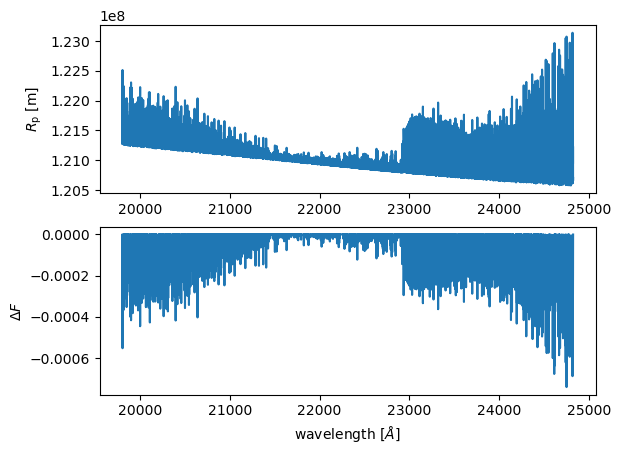

In [4]:
#1D atmosphere pars
Rstar = 1.458*const.R_sun.value #stellar radius in m
Mpl = 1.184*const.M_jup.value #planet mass in kg
Rpl = 0.118*Rstar #stellar radius in m
g = const.G.value * Mpl / Rpl**2 #surface gravity m/s^2
mmw = 2.33 #mean molecular weight
P0 = 1.e-2 #reference pressure in bars

#load in the cross-sections using provided function
wl,temp_grid,pressure_grid,xs = xs_DACE_multi('H2O CO'.split(),wl=d['wl_model'],units='m2')

#strip pressure dependence from cross-sections to simplify
xs[0] = xs[0].squeeze()
xs[1] = xs[1].squeeze()

#define semi-analytical model
model = semianalytical(wl,Rpl,P0,g,mmw,Rstar,temp_grid,xs)

#important to note that pars are not in log space here
#test the model, note pars = [temp,Pcloud,mix_h2,vel_broad,mixing_ratios x Nspecies]
r = model(np.array([2300,1e-2,1] + [2] + [1e-5,1e-5]))

sigma = 3
template = model.tspec_ndf(p_inject)
template = model.tspec_ndf(np.array([2300,1e-2,1] + [sigma] + [1e-5,1e-5]))
template_h2o = model.tspec_ndf(np.array([2300,1e-2,1] + [sigma] + [1e-5,1e-100]))
template_co = model.tspec_ndf(np.array([2300,1e-2,1] + [sigma] + [1e-100,1e-5]))

fig,ax = plt.subplots(2)
ax[0].plot(wl,model(np.array([2300,1e-2,10000] + [2] + [1e-5,1e-5])),'-')
ax[1].plot(wl,template,'-')
ax[0].set_ylabel(r'$R_{\rm p}$ [m]')
ax[1].set_ylabel(r'$\Delta F$')
_ = ax[1].set_xlabel(r'wavelength [$\AA$]')

### Preprocessing the data

We're going to keep things simple and use a weighted PCA (which accounts for noise along columns, i.e. wavelength dependence). But we will use a more generic filtering process so you can easily use SysRem instead if you prefer.

Generally, the first step is to *divide* the spectra through by the stellar + telluric model, which is cricital to preserving the line depths and remaining consistent with our model. Often, we do this by first dividing through by the average spectrum, then apply PCA / SysRem. But an alternative is to use PCA / SysRem to model the stellar + telluric spectra directly. In this case, it is crucial to divide through by the full model to preserve line depths. If we first divide by the average spectrum, it is ok to then subtract a PCA / SysRem model - even if the systematics fit by the model are multiplicative, if they are small then this is a good approximation.

We are going to use 5 PCA components. The simulations actually have no systematics injected, but we should still be able to filter our data and get the consistent results.


In [5]:
# first we do a mean division and scale the noise appropriately
S_ave = np.mean(S,axis=-2)[...,None,:]
with np.errstate(divide='ignore',invalid='ignore'):
  X = S / np.abs(S_ave)
  Xe = Se / np.abs(S_ave)
#clean up any bad datapoints (from zero division in the normalisation)
Xe[np.isnan(X)] = np.inf
X[np.isnan(X)] = 0.

# perform sysrem and subtract model from X
N_components = 5 # let's remove 5 components. How do we get this number in general!? A thorny model selection problem...
# run PCA -> this version will do a mean subtraction and column normalisation first, which weights the columns when exactracting basis U
U,Weights,M = preprocessing.pca(X,N=N_components,mean_sub=True,add_bias=True,norm_cols=True) # run PCA

# we can double check that we get exact same model when refitting...
# The full linear fit is U (U^T U)^{-1} U.T Y, but (U^T U)^{-1} is the identity matrix for orthogonal basis functions
M_refit = np.einsum('...aj,...tj,...tl->...al',U,U,X,optimize=True)
print("fitting ok?",np.all(np.isclose(M,M_refit))) # show that re-fitting is identical

# should we refit using the time-dependent noise??
# to do this we need to use the uncertainties as this 'breaks' the 'orthogonality' of the basis vectors
inv_stdev = 1./np.nanmean(np.where(np.isfinite(Xe),Xe,np.nan),axis=-1)
psinv_scaled = np.linalg.pinv(U * inv_stdev[:,:,np.newaxis]) * inv_stdev[:,np.newaxis,:]
M = np.einsum('...aj,...jt,...tl->...al',U,psinv_scaled,X,optimize=True) # I've changed the order of the 2nd term as U^dagger is transposed
print("fitting with uncertainties should be different so=false:",np.all(np.isclose(M,M_refit))) # show that this is different?

# we can also double check if the basis vectors are orthogonal
# this is guaranteed from PCA (but we also added a bias term, it should still be orthogonal if we've subtracted a mean)
print("are the basis funcitons orthogonal basis?",np.all(np.isclose( U[0].T @ U[0], np.eye(U[0,0].size))))

# we then want to get the residuals from the model - M is rescaled back according to mean sub / normalisation above
R = X - M # residuals
Re = Xe # if subtracting the model then uncertainties are the same

#check for any bad data in our arrays
print(np.isnan(R).sum())
print(np.isnan(Re).sum())
print(np.isinf(R).sum())
print(np.isinf(Re).sum()) # infs are fine in the uncertainties as it just removes them from the inference

fitting ok? True
fitting with uncertainties should be different so=false: False
are the basis funcitons orthogonal basis? True
0
0
0
39600


### Cross-correlation + Velocity Sum

This was covered in yesterday's tutorial. Let's just run a simple version to check what's in the data! We'll define a simple cross-correlation and a simple velocity summation function.


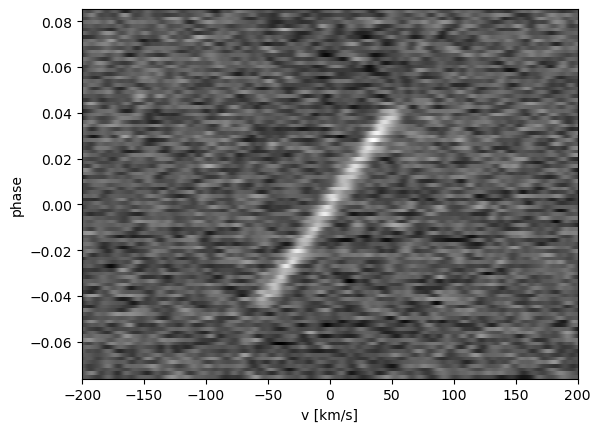

In [6]:
#define velocity and Kp for our search
v = np.linspace(-200,200,1000) #define range to perform cc, in km/s
K = np.linspace(-300,300,600)

def cross_correlate(v,W,R,Re,wl,template):
    """
    Simple cross-correlation function, looping over every order.
    This uses simple linear interpolation - this isn't always appropriate !!
    """
    
    CC = np.empty((R.shape[0],R.shape[1],v.size)) #create empty array for CC function
    for order in range(CC.shape[0]): #loop over orders
    
        W_shifted = np.outer((1.-v/299792.458),W[order]) #create array of shifted wavelengths for each v_sys
        shifted_templates = np.interp(W_shifted,wl,template) #interpolate the template model to every v_sys
    
        #and compute the cross correlation as before
        CC[order] = np.dot(R[order]/Re[order]**2,shifted_templates.T)

    return CC

plt.subplots(1)
CC = cross_correlate(v,W,R,Re,wl,template).sum(axis=0)
plt.pcolormesh(v,ph,CC)
plt.xlabel('v [km/s]')
_ = plt.ylabel('phase')
#plt.pcolormesh(v,ph,CC-np.median(CC,axis=-1)[...,None]) # sometimes want to subtract average depending on normlisation of model

In [7]:
def vel_sum(ph,v,CC,K,tweight=None,norm=True,K_lims=[-250,-150],v_lims=[-100,100]):
  """
  Simple function to do a velocity summation over planet's velocity
  """
  if tweight is None: #by default weight everything equally
    tweight = np.ones(CC.shape[0])   
  
  #define arrays for storage
  shifted = np.empty(CC.shape)
  CC_map = np.empty((K.size,v.size))

  #loop over the Ks
  for i in range(K.size):
    vp = K[i]*np.sin(ph*2.*np.pi) #+25 #compute vp for each K
    for j in range(vp.size): #loop over velocities and interpolate to planet's rest frame assuming given Kp
      shifted[j] = np.interp(v+vp[j],v,CC[j])

    #store weighted sum for each Kp
    CC_map[i] = np.sum(shifted * tweight[:,None], axis=0)
  
  if norm:
    CC_map_noise = CC_map[(K>K_lims[0])*(K<K_lims[1]),:][:,(v>v_lims[0])*(v<v_lims[1])]
    CC_map = (CC_map - CC_map_noise.mean()) / CC_map_noise.std() # rescale map to get noise
    
  return CC_map


In [8]:
#let's sum over the CC function to get Kp-vys map
CC_map = vel_sum(ph,v,CC,K,tweight=tweight,norm=1) #it doesn't make any difference whether we subtract the mean

#we'll also repeat for the CO and H2O models
CC_h2o = cross_correlate(v,W,R,Re,wl,template_h2o).sum(axis=0)
CC_co = cross_correlate(v,W,R,Re,wl,template_co).sum(axis=0)
CC_map_h2o = vel_sum(ph,v,CC_h2o,K,tweight=tweight,norm=1) #it doesn't make any difference whether we subtract the mean
CC_map_co = vel_sum(ph,v,CC_co,K,tweight=tweight,norm=1) #it doesn't make any difference whether we subtract the mean

signal @ K=[199.83305509], v=[-0.2002002]


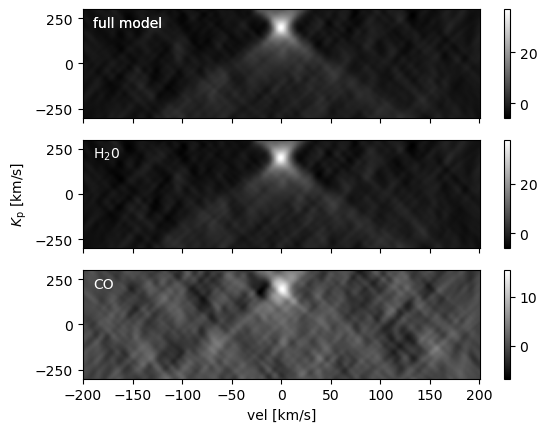

In [9]:
f,ax = plt.subplots(3,sharex=True)
q = ax[0].pcolormesh(v,K,CC_map)
plt.colorbar(q)
ax[0].text(-190,200,'full model',color='w')
q = ax[1].pcolormesh(v,K,CC_map_h2o)
plt.colorbar(q)
q = ax[2].pcolormesh(v,K,CC_map_co)
plt.colorbar(q)
plt.xlabel('vel [km/s]')
ax[1].set_ylabel(r'$K_{\rm p}$ [km/s]')

ax[0].text(-190,200,'full model',color='w')
ax[1].text(-190,200,'H$_2$0',color='w')
_ = ax[2].text(-190,200,'CO',color='w')

#let's check where the peak signal is found (hopefuly close to the injected values!!)
kp_max,v_max = np.where(CC_map==CC_map.max())
print("signal @ K={}, v={}".format(K[kp_max],v[v_max]))

### The 3D forward model

Now we've explored some basics of the dataset, let's start to build up a 3D forward model and compute the likelhood function.

First let's define a basic function to compute the 3D forward model. This takes in a 1D model, addionally Kp and v_sys parameters, then interpolates the 1D model into a 3D array.


In [10]:
def model3D(pars,phase,W,wl_model,model1D,transit_weight,bvc=0,out=None,temp_array=None):
  """
  pars - parameter vector for our forward model
  phase - orbital phase
  W - 2D wavelength array (ie for each order) [all wavelengths are in Angstrom]
  model1D - callable 1D model, assuming that it is normalised to 0 (ie continuum of planet spec is at 0)
  transit_weight - weighting vector to apply transit model weighting
  bvc - barycentric velocity correction can be added if required and/or correction for v_sys
  out - array to store model (not required, but predefining memory can sometimes speed things up a lot!)
  temp_array - other array for outputs
  
  """
  
  #compute planet velocity
  vp = pars[7]*np.sin(phase*2.*np.pi) + pars[6] + bvc

  #pre-compute (1-vp/c)
  one_minus_v_c = 1. - vp*3.3356409519815205e-06
  
  #call the 1D model with first 6 parameters
  template = model1D(pars[:6])

  #define the output array - this can be provided to (potentially) speed things up
  if out is None: out = np.empty([W.shape[0],phase.size,W.shape[1]])
  
  #loop over orders and interpolate 1D model to 2D grid for each
  for ord in range(W.shape[0]):
    
    #get new wavelength array to interpolate to
    W_shifted = np.outer(one_minus_v_c,W[ord],out=temp_array)
    
    #pass only subset of 1D model - this can speed things up but haven't checked recently
    low,up = np.searchsorted(wl_model,[W_shifted.min(),W_shifted.max()])
    
    #interpolate to output
    out[ord] = np.interp(W_shifted,wl_model[low:up+1],template[low:up+1]) * transit_weight[:,np.newaxis] #signal relative to zero continuum
        
  return out


Text(0, 0.5, 'flux')

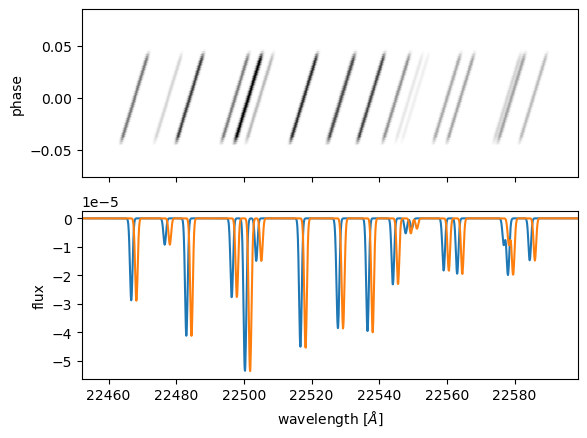

In [11]:
# let's test the forward model works ok
p = np.array([Temp,Pcloud,Xray,dv,Xh2o,Xco] + [v_sys,Kp])

# for this version, we should use the differential flux to subtract the continuum
args = [ph,W,wl,model.tspec_ndf,tweight]
FM = model3D(p,*args)

#plot up the model for a specific order plus a few slices
fig,ax = plt.subplots(2,sharex=True)
ax[0].pcolormesh(W[order],ph,FM[order])
ax[1].plot(W[order],FM[10,40])
ax[1].plot(W[order],FM[10,50])
ax[1].set_xlabel(r'wavelength [$\AA$]')
ax[0].set_ylabel(r'phase')
ax[1].set_ylabel(r'flux')

### The likelihood function

Now that we have a forward model, we can define our likelihood.

We also want to consider reparameterising some of our inputs, as we'd like to fit for the log of the cloud deck pressure, and the log of the abundances. We'll handle that within the likelhood.


In [12]:
def log_likelihood(pars,model_3D,phase,W,R,Re,wl_model,model1D,transit_weight,*args,bvc=0,out=None,temp_array=None):
  """
  Simple function to compute the log Likelihood. We'll add in a generic *args so we can add more inputs later.

  There are two extra pars to add - alpha and beta
  
  """
  p = np.copy(pars) # copy the vector
  p[1:3] = 10**p[1:3] # Pcloud + X_ray
  p[4:6] = 10**p[4:6] # abundances
  
  #compute 3D model
  M3D = model_3D(p[:-2],phase,W,wl_model,model1D,transit_weight,*args,bvc=bvc,out=out,temp_array=temp_array)

  #make a transit filter - should we only compute the likelihood for points within the transit!? I'm not particularly sure anymore...
  tfilter = transit_weight > 0

  #compute the chi2
  chi2 = np.square((R[:,tfilter,:] - p[-2]*M3D[:,tfilter,:]) / Re[:,tfilter,:]).sum() / p[-1]**2
  
  #get the effective number of parameters (we should ignore any infs in the noise as they don't contribute to beta!)  
  Neff = np.isfinite(Re[:,tfilter,:]).sum() # move outside likelihood?
  
  return -0.5 * chi2 - Neff * np.log(p[-1])


In [13]:
# let's test the likelihood works ok - remember to add alpha and beta to the vector
# also remember we are passing the log10 of some parameters now...
p = np.array([Temp,np.log10(Pcloud),np.log10(Xray),dv,np.log10(Xh2o),np.log10(Xco)] + [v_sys,Kp] + [1,1])

#predefine the arguments list
args = [ph,W,R,Re,wl,model.tspec_ndf,tweight]
print("logL =", log_likelihood(p,model3D,*args))

logL = -965882.3850328443


### Defining a prior and the posterior distribution

Our final step before being ready to consider a retrieval is to define our prior and our posterior distribution. We're just going to use a simple (improper) uniform prior, where we simply set lower and upper bounds for each of our parameters.


In [14]:
#let's just define lower and upper limits as a list of tuples
bounds = [(1000,4000),(-3,2),(-10,5),(1,10),(-10,-2),(-10,-2),(-50,50),(150,250),(0.1,2),(0.5,2)]

#while we're at it let's define a list of labels for our parameters (useful for plotting)
labels = [r'$T$',r'$P_{\rm cloud}$',r'$\chi_{\rm Ray}$',r'$\Delta{V}$',r'$\chi_{\rm H_2O}$',r'$\chi_{\rm CO}$',r'$v_{\rm sys}$',r'$K_{\rm p}$',r'$\alpha$',r'$\beta$']

#we can just use a little wrapper function from mini_inferno
logP = apply_uniform_logPrior(log_likelihood,bounds) #apply prior to logL using transit uniform bounds

#let's test it - should just give us the same value unless we step out of the prior bounds, where it returns -np.inf
print("logP =", logP(p,model3D,*args))
print("logP =", logP(np.array([800,-2,0] + [5.021643907242071] + [-5,-5] + [0,200] + [1,1]),model3D,*args))

logP = -965882.3850328443
logP = -inf


Instead of a retreival, let's just take a slice through our posterior for now:

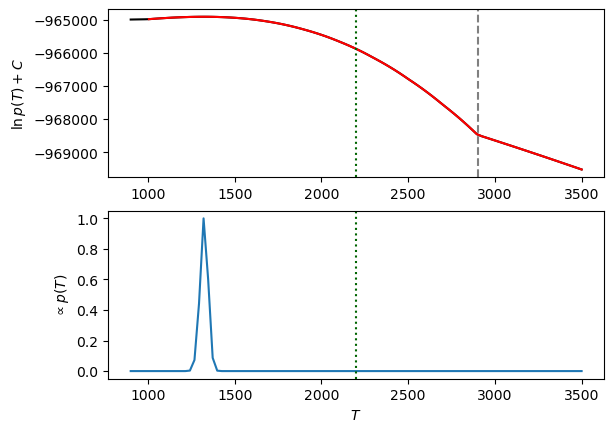

In [15]:
#let's define a range of temperatures and keep everything else fixed
temps = np.linspace(900,3500,100) # define a range of temperatures

logL_slice = [log_likelihood(np.array([q,np.log10(Pcloud),np.log10(Xray),dv,np.log10(Xh2o),np.log10(Xco)] + [v_sys,Kp] + [1,1]),model3D,*args) for q in temps]
logP_slice = [logP(np.array([q,np.log10(Pcloud),np.log10(Xray),dv,np.log10(Xh2o),np.log10(Xco)] + [v_sys,Kp] + [1,1]),model3D,*args) for q in temps]

#then lets plot them
fig,ax = plt.subplots(2)
ax[0].plot(temps,logL_slice,'k-')
ax[0].plot(temps,logP_slice,'r-')
ax[1].plot(temps,np.exp(logL_slice-np.max(logL_slice)))
ax[1].axvline(Temp,ls=':',color='darkgreen') # plot actual value
ax[0].axvline(Temp,ls=':',color='darkgreen') # plot actual value
ax[0].set_ylabel(r'$\ln p(T) + C$')
ax[1].set_ylabel(r'$\propto p(T)$')
ax[1].set_xlabel(r'$T$')
ax[0].axvline(temp_grid[0][-1],ls='--',color='0.5')

Hmm, we're way off! The maximum likelihood / posterior is way smaller than it ought to be! What is going wrong? Let's try another parameter.

(The weird kink at $\sim2,900$K is related to the maximum temperature of the cross-section available. So the cross-section is no longer changing, just the scale height)

Text(0.5, 0, '$\\alpha$')

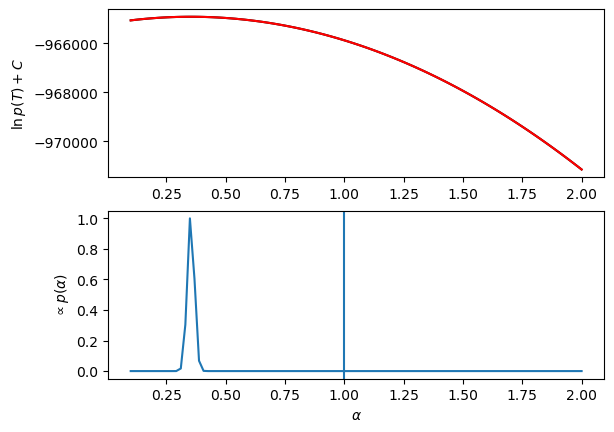

In [16]:
#let's define a range of temperatures and keep everything else fixed
alpha_slice = np.linspace(0.1,2,100) # define a range of temperatures
logL_slice = [log_likelihood(np.array([Temp,np.log10(Pcloud),np.log10(Xray),dv,np.log10(Xh2o),np.log10(Xco)] + [v_sys,Kp] + [q,1]),model3D,*args) for q in alpha_slice]
logP_slice = [logP(np.array([Temp,np.log10(Pcloud),np.log10(Xray),dv,np.log10(Xh2o),np.log10(Xco)] + [v_sys,Kp] + [q,1]),model3D,*args) for q in alpha_slice]

#then lets plot them
fig,ax = plt.subplots(2)
ax[0].plot(alpha_slice,logL_slice,'k-')
ax[0].plot(alpha_slice,logP_slice,'r-')
ax[1].plot(alpha_slice,np.exp(logL_slice-np.max(logL_slice)))
ax[1].axvline(1) # plot actual value
ax[0].set_ylabel(r'$\ln p(T) + C$')
ax[1].set_ylabel(r'$\propto p(\alpha)$')
ax[1].set_xlabel(r'$\alpha$')

Again, we're way off! Let's think again about our forward model.

One thing we do with the data is that we normalise it by dividing through by the mean of the spectra (or we might do some more complex blaze correction). But ultimately we normalise the data so it's all roughly on the same level. As the exoplanet's signal is also there, we must do the same thing with our forward model. So the first correction we'll make is just to divide each spectrum (more specifically each spectral order) by the mean along the wavelength direction. To do this we'll write a new foward model.

In [17]:
def model3D_with_norm(pars,phase,W,wl_model,model1D,transit_weight,bvc=0,out=None,temp_array=None):
  """
  same as before - now with some normalisation...  
  """
  
  #compute planet velocity
  vp = pars[7]*np.sin(phase*2.*np.pi) + pars[6] + bvc

  #pre-compute (1-vp/c)
  one_minus_v_c = 1. - vp*3.3356409519815205e-06
  
  #call the 1D model with first 6 parameters
  template = model1D(pars[:6])
  
  if out is None: out = np.empty([W.shape[0],phase.size,W.shape[1]])
  
  #loop over orders and interpolate 1D model to 2D grid for each
  for ord in range(W.shape[0]):
    
    #get new wavelength array to interpolate to
    W_shifted = np.outer(one_minus_v_c,W[ord],out=temp_array)
    
    #pass only subset of 1D model - this can speed things up a lot!
    low,up = np.searchsorted(wl_model,[W_shifted.min(),W_shifted.max()])
    
    #interpolate to output - cannot provide output to np.interp function, but this would speed things up
    out[ord] = np.interp(W_shifted,wl_model[low:up+1],template[low:up+1]) * transit_weight[:,np.newaxis] #signal relative to zero continuum

    #mimic the 'blaze' correction. Add 1 to the model, divide by mean, then subtract 1 to match data
    # (note that for large datasets even simple operations like this can be costly, so important to careful test + optimise!)
    np.add(out[ord],1,out=out[ord])
    np.divide(out[ord], np.mean(out[ord],axis=-1)[...,np.newaxis],out=out[ord])
    np.subtract(out[ord], 1, out=out[ord])

  return out


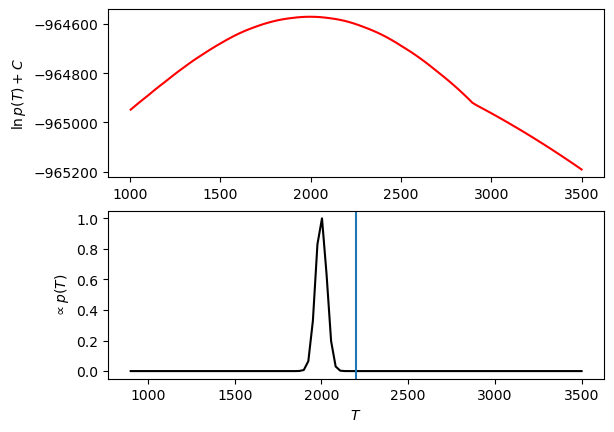

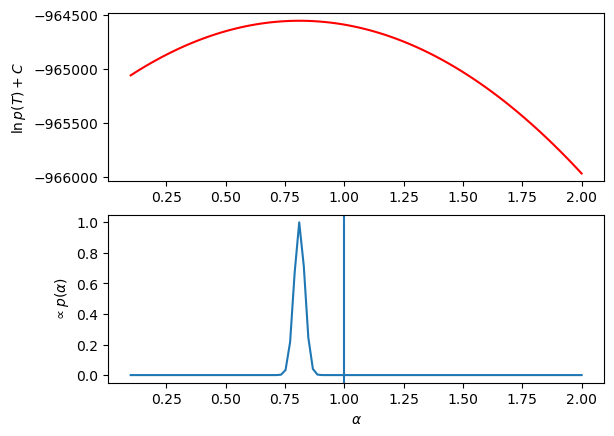

In [18]:
#let's do the same again with our new model
logP_slice = [logP(np.array([q,np.log10(Pcloud),np.log10(Xray),dv,np.log10(Xh2o),np.log10(Xco)] + [v_sys,Kp] + [1,1]),model3D_with_norm,*args) for q in temps]

fig,ax = plt.subplots(2)
ax[0].plot(temps,logP_slice,'r-')
ax[1].plot(temps,np.exp(logP_slice-np.max(logP_slice)),'k-') # scale so max prob=1, no need to fully normalise
ax[1].axvline(Temp) # plot actual value
ax[0].set_ylabel(r'$\ln p(T) + C$')
ax[1].set_ylabel(r'$\propto p(T)$')
ax[1].set_xlabel(r'$T$')

#let's define a range of temperatures and keep everything else fixed
#alpha_slice = np.linspace(0.1,2,100) # define a range of temperatures
#logL_slice = [log_likelihood(np.array([2300,-2,0] + [5.021643907242071] + [-5,-5] + [0,200] + [q,1]),model3D_with_norm,*args) for q in alpha_slice]
#logP_slice = [logP(np.array([2200,-2,0] + [5.021643907242071] + [-5,-5] + [0,200] + [q,1]),model3D_with_norm,*args) for q in alpha_slice]
logP_slice = [logP(np.array([Temp,np.log10(Pcloud),np.log10(Xray),dv,np.log10(Xh2o),np.log10(Xco)] + [v_sys,Kp] + [q,1]),model3D_with_norm,*args) for q in alpha_slice]

#then lets plot them
fig,ax = plt.subplots(2)
#ax[0].plot(alpha_slice,logL_slice,'k-')
ax[0].plot(alpha_slice,logP_slice,'r-')
ax[1].plot(alpha_slice,np.exp(logP_slice-np.max(logP_slice)))
ax[1].axvline(1) # plot actual value
ax[0].set_ylabel(r'$\ln p(T) + C$')
ax[1].set_ylabel(r'$\propto p(\alpha)$')
_= ax[1].set_xlabel(r'$\alpha$')

That's already a lot better! This is just a simple example to show that mimicing *exactly* what is done to the data is the critcal way to a reliable and accurate retrieval.

However, it's still not particularly great, right? The reason is that we still haven't considered how the filtering affects the model. Once we do that, we should be in much better shape.

Using this new normalised setup, we could also just use our 'normal' transit model rather than the continuum subtracted version, i.e.: `args = [ph,W,R,Re,wl,model.tspec_nf,tweight]`


## Filtering

The next thing we want to implement is the filter that mimics what PCA / SysRem did to our data. Here I will provide some code demonstrating how the filter works, and you can build it into the forward 3D model. If you are unfamiliar with matrix algebra, this might seems a little complicated at first, but I promise you it is very straightforward linear algebra!

As discussed in the lecture, the filter is just built from the basis vectors extraced from the PCA / SysRem decomposition, as well as the (potentially important) bias term. To get the weights we just have to apply the simple linear regression functions we discussed earlier:
$$
\boldsymbol {W = (U^\top U)^{-1} U^\top Y = U^\dagger Y} 
$$
To accomodate noise we can modify slightly:
$$
\boldsymbol {W = (U^\top \boldsymbol\Sigma^{-1} U)^{-1} U^\top \boldsymbol\Sigma^{-1} Y}
$$
Here, $\boldsymbol\Sigma$ is the covariance matrix. We're going to simplify this expression by assuming a diagonal covariance matrix (i.e. with each diagonal term is $\sigma_i^2$), and defining $\boldsymbol{\Sigma^{-1} = \Lambda\Lambda}$. This means the diagonal terms in $\boldsymbol\Lambda$ just contain $1/\sigma_i$. We can now rewrite the above equation in the following way.
$$
\boldsymbol {W = (U^\top \boldsymbol{\Lambda\Lambda} U)^{-1} U^\top \boldsymbol{\Lambda\Lambda} Y},
$$
and because $\Lambda= \Lambda^\top$ we can write as:
$$
\boldsymbol {W = ((\boldsymbol{\Lambda}U)^\top \boldsymbol{\Lambda} U)^{-1} (\boldsymbol{\Lambda}U)^\top \boldsymbol{\Lambda} Y} = (\boldsymbol{\Lambda}U)^\dagger \boldsymbol{\Lambda Y}
$$
Keep in mind that $\boldsymbol{F} = (\boldsymbol{\Lambda U})^\dagger \boldsymbol{\Lambda}$ is just a fixed matrix, which we can store as a filtering matrix.

To get the final fit to our data or model, we can just pre-multiply again by our basis vectors $\boldsymbol{U}$:
$$
\boldsymbol {M}^\prime = \boldsymbol{U}(\boldsymbol{\Lambda U})^\dagger \boldsymbol{\Lambda Y} = \boldsymbol{U F Y}.
$$
(note that in priniple we could incorporate the initial $\boldsymbol {U}$ in our pre-computed filter, but due to the shapes of the matrices this is typically slower to compute - you can ask me why!)

So, in order to generate a *filtered* forward model, we can simply generate the forward model as before, then apply the filter above to the 3D model, and simply subtract the result to obtain a filter model. As this is just a few matrix muliplications, this procedure is fast - much faster than PCA (where we have to determine the basis vectors as well as fit them) and orders of magnitude faster than SysRem.

The following will walk through how we apply a filter to a 3D model. Remember, we already have the basis vectors $\boldsymbol U$, and have added a bias vector to it.

-0.007170708936972845
-1.2074970412060157e-17


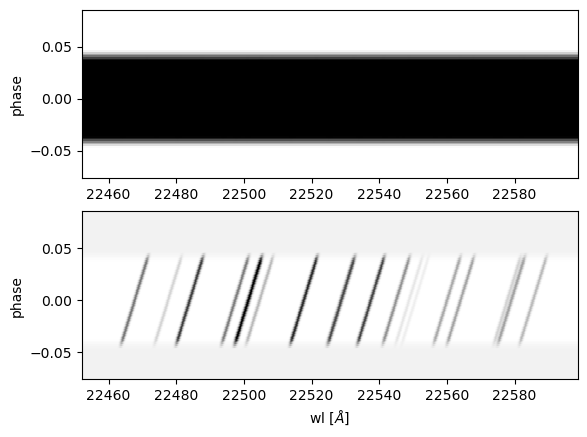

In [19]:
#let's first generate our forward model as before
p = np.array([Temp,Pcloud,Xray,dv,Xh2o,Xco] + [v_sys,Kp]) # the model takes the 'un-logged'/original parameters
args = [ph,W,wl,model.tspec_nf,tweight]

#let's create both an unnormalised and normalised version:
FM = model3D(p,*args)
FMN = model3D_with_norm(p,*args)

print(FM.mean())
print(FMN.mean())
#plot up the model
fig,ax = plt.subplots(2)
ax[0].pcolormesh(W[10],ph,FM[10])
ax[1].pcolormesh(W[10],ph,FMN[10])
ax[1].set_xlabel(r'wl $[\AA]$')
ax[0].set_ylabel(r'phase')
_ = ax[1].set_ylabel(r'phase')

In [20]:
#now let's compute our filter

#can just get the psuedo-inverse for all orders (for >2D arrays first order is independent)
psinv = np.linalg.pinv(U)

#but in general, we want to be able to weight according to our uncertainties
#let's then compute the mean inverse standard deviation, just the diagonal of the matrix Lambda (we never need to store a fulll diagonal matrix)
inv_stdev = 1./np.nanmean(np.where(np.isfinite(Re),Re,np.nan),axis=-1)

#then lets compute the pinv of (Lambda U)
psinv = np.linalg.pinv(U * inv_stdev[:,:,np.newaxis])

#instead however, we want to absorb the final lambda in our filter (see equations above)
psinv_scaled = np.linalg.pinv(U * inv_stdev[:,:,np.newaxis]) * inv_stdev[:,np.newaxis,:]
#psinv_scaled = np.linalg.pinv(U)


Ok, we are now (finally!) ready to apply our filter:

In [21]:
#let's predefine memory, and just do it order by order to keep things simple
# (you could also do it with 1 line with np.einsum, but not sure you gain much)
filtered_model = np.empty([W.shape[0],ph.size,W.shape[1]])
for ord in range(W.shape[0]):
  #np.linalg.multi_dot([U[ord],psinv_scaled[ord],FMN[ord]+1],out=filtered_model[ord])
  np.subtract(FMN[ord],np.linalg.multi_dot([U[ord],psinv_scaled[ord],FMN[ord]]),out=filtered_model[ord])

#filtered_model -= 1 # subtract 1 from the filtered model


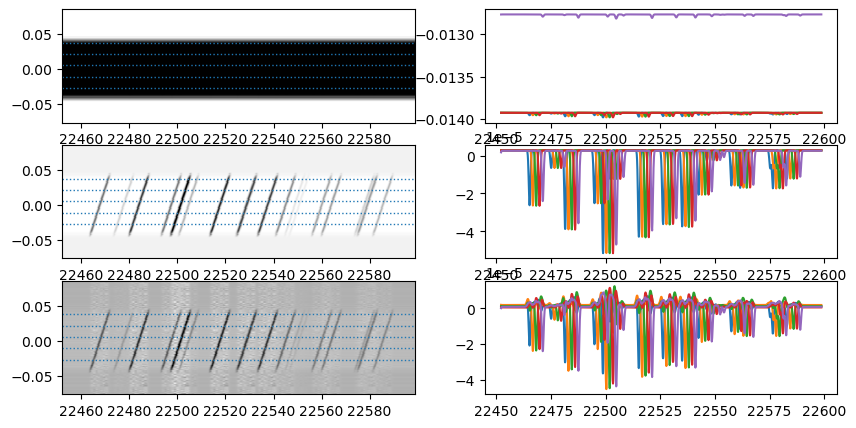

In [22]:
#let's plot it up and see

fig,ax = plt.subplots(3,2,figsize=[10,5])
ax[0,0].pcolormesh(W[10],ph,FM[10])
ax[1,0].pcolormesh(W[10],ph,FMN[10])
ax[2,0].pcolormesh(W[10],ph,filtered_model[10])

for q in [30,40,50,60,70]:
    ax[0,1].plot(W[10],FM[10,q])
    ax[1,1].plot(W[10],FMN[10,q])
    ax[2,1].plot(W[10],filtered_model[10,q])
    ax[0,0].axhline(ph[q],lw=1,ls=':')
    ax[1,0].axhline(ph[q],lw=1,ls=':')
    ax[2,0].axhline(ph[q],lw=1,ls=':')
    

And we're done pretty much done with the filtering!!

One major issue that you might have noticed is that we used a single uncertainty vector / matrix for the fit. This means that we're not taking into account the uncertainties in each row. However, this isn't so bad. Recall the equation:
$$
\boldsymbol {W = (U^\top \boldsymbol\Sigma^{-1} U)^{-1} U^\top \boldsymbol\Sigma^{-1} Y}
$$
If I scale my uncertainties by a constant, say by replacing $\boldsymbol\Sigma = \beta\boldsymbol\Sigma$, and sub into the equation we get:
$$
\begin{align}
\boldsymbol {W} &= \boldsymbol {W(U^\top (\beta\boldsymbol\Sigma)^{-1} U)^{-1} U^\top (\beta\boldsymbol\Sigma)^{-1} Y}\\
&= \beta\beta^{-1}\boldsymbol {W(U^\top \boldsymbol\Sigma^{-1} U)^{-1} U^\top \boldsymbol\Sigma^{-1} Y}
\end{align}
$$
i.e. the scale factor cancels. Therefore we only need to get the scaling of the noise correct. Therefore if we assume that the noise has the same time-dependence, then we can just use the average uncertainties. This is exact when we use outer-product approximations for the noise (reasonable common), but may break down in reality. Unfortunately taking the noise independently for each column (ie time-series) would require us to invert and store (or psuedo-inverse) [$N_{\rm orders} \times N_{\rm \lambda}$] matrices, which isn't super efficient. This approximation has worked for all tests I have tried, but will likely fail in certain circumstances. There are a few tricks we can use to improve this, but for now this will do!


### Your Task

Now that we have written a basic forward model, likelhood and prior, as well as looked into the filtering, it is now your turn to do some work.

1) First, create a new forward (3D) model that returns a filtered model
2) Next, re-compute the conditional distrubutions as above
3) Pass the $\log P$ into your favorite MCMC or inference algorithm, and see if you can run a full retrieval. You might want to try optimising the model first (though we already know the rough outcome). Getting a rough approximation of the uncertainties will always help in performing an efficient sampler (if you are new to MCMC, let me know and I can provide some code).
4) For experienced retrievers, you could try optimising the above functions. There are speed gains to be made!

For those in need of a greater challenge, I can provide reduced transit data of WASP-121b taken with UVES so you can test these methods on real data. Or you might want to try them on some of your own data!
